In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
from Optimizers.SampleWeighting import CauchySimplex, EGD, PairwiseFrankWolfe
from Optimizers.SampleWeighting.Distributions import TruncatedGaussian
from Optimizers.SampleWeighting.SampleWeighting import SampleWeighting

In [4]:
def generate_student_scores(num_students=100, num_questions=100, 
                            easy_question_proportion=0.8, smart_student_proportion=0.6):
    # Question difficulty
    q_values = np.zeros(num_questions)
    n = int(num_questions * easy_question_proportion)

    q_values[:n] = np.random.rand(n) / 4 + 0.75
    q_values[n:] = np.random.rand(num_questions - n) / 3

    # Student smartness
    p_values = np.zeros(num_students)
    n = int(num_students * smart_student_proportion)

    p_values[:n] = np.random.rand(n) / 5 + 0.6
    p_values[n:] = np.random.rand(num_students - n) / 3 + 0.5

    return np.random.binomial(1, p_values[:, None] * q_values[None, :], size=(num_students, num_questions))

In [5]:
num_trials = 25

max_iter = 200
max_time = np.inf  # seconds

num_students = 100
num_questions = 100

integration_points = np.linspace(0, 1, 401)
target_distribution = TruncatedGaussian(0.7, 0.1, 0, 1)

In [6]:
np.random.seed(0)

samples = generate_student_scores(num_students=num_students, num_questions=num_questions)
_, n = samples.shape

In [7]:
optimizer = CauchySimplex(samples, integration_points, target_distribution, e=0.05)
w = np.ones(n) / n

w_history = [(0, w.copy())]

for i in range(10):
    w = optimizer.search(w)
    
    if i == 1:
        w_history.append((i + 1, w.copy()))
        
w_history.append((i + 1, w.copy()))

In [8]:
for i, w in w_history:
    marks = samples @ w
    
    mean = np.mean(marks)
    std = np.std(marks)
    
    print(f"Iteration {i}: Mean = {mean:.3f}, Std = {std:.3f}")

Iteration 0: Mean = 0.504, Std = 0.069
Iteration 2: Mean = 0.619, Std = 0.085
Iteration 10: Mean = 0.683, Std = 0.093


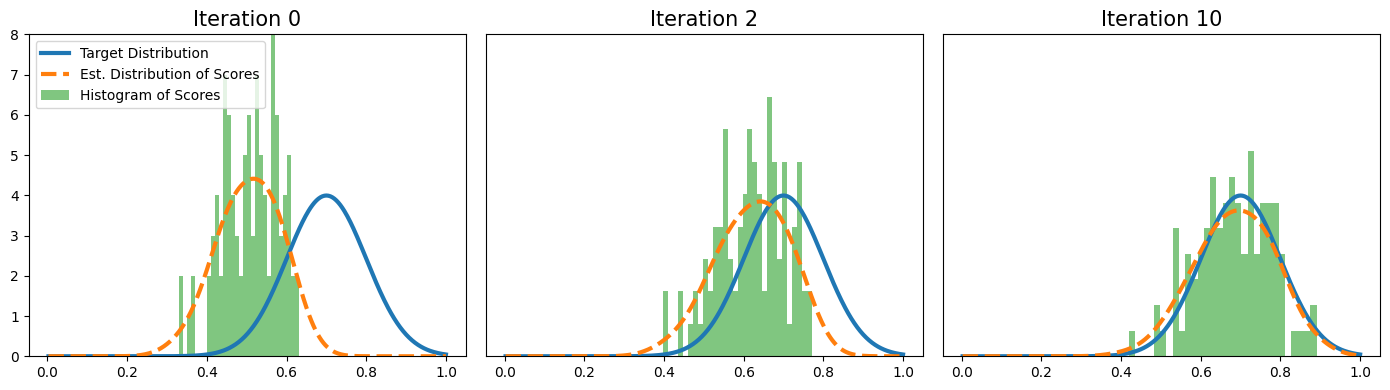

In [9]:
x_vals = integration_points[1:]

plt.figure(figsize=(14, 4))

for i, (iteration, w) in enumerate(w_history):
    plt.subplot(1, 3, i + 1)

    plt.plot(x_vals, optimizer.target_distribution(x_vals), label='Target Distribution', 
             zorder=3, linewidth=3)
    plt.plot(x_vals, optimizer.rho(w), label='Est. Distribution of Scores', 
             linestyle='--', zorder=3, linewidth=3)
    
    plt.hist(samples @ w, density=True, bins=30, label='Histogram of Scores', zorder=1, alpha=0.6)
    
    plt.ylim(0, 8)
    
    plt.title(f"Iteration {iteration}", size=15)
    
    if i > 0:
        plt.yticks([], [])
    else:
        plt.legend(loc='upper left')
    
plt.tight_layout()
plt.savefig("mark_distribution.png", dpi=150);